<a href="https://colab.research.google.com/github/alinespereira/alshenawy-distribution/blob/main/Alshenawy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext rich

```bash
%%bash
git clone https://github.com/alinespereira/alshenawy-distribution
mv alshenawy-distribution/distributions .
mv alshenawy-distribution/stats .
rm -rf alshenawy-distribution
```

In [2]:
%%bash
rm -rf distributions stats
git clone https://github.com/alinespereira/alshenawy-distribution
mv alshenawy-distribution/distributions .
mv alshenawy-distribution/stats .
rm -rf alshenawy-distribution

Cloning into 'alshenawy-distribution'...


In [3]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
from scipy import stats, optimize
import matplotlib.pyplot as plt
import seaborn as sns

from distributions.rv import a
from distributions.continuous import A
from stats import classical, bayesian
from stats.utils import summarize

In [4]:
plt.style.use("arviz-darkgrid")

# Estudo de simulação

In [5]:
REPLICATIONS: int = 10
SAMPLE_SIZES: list[int] = [25, 50, 100, 200, 400]
BETAS: list[float] = [0.125, 0.6, 1.0]

In [6]:
RANDOM_SEED: int = 42
RNG: np.random.Generator = np.random.default_rng(RANDOM_SEED)

# Estudo de simulação clássico

In [7]:
betas = np.repeat(np.logspace(-2, 2, num=20), 10)
samples = np.vstack([
    a(beta=beta).rvs(size=100).mean()
    for beta in betas
]).flatten()

In [8]:
simulations = {}
np.random.seed(RANDOM_SEED)

for beta in BETAS:
    simulations[beta] = {}
    rv = a(beta=beta)
    print(f"{beta = }")
    for n in SAMPLE_SIZES:
        simulations[beta][n] = []
        print(f"\t{n = }")
        for i in range(REPLICATIONS):
            sample = rv.rvs(size=n)
            negative_log_likelihood = lambda beta_: -a(beta=beta_[0]).logpdf(sample).sum()
            simulation = classical.simulate(
                param=beta,
                negative_log_likelihood=negative_log_likelihood,
                initial_guess=0.05,
                sample_size=len(sample),
                alpha=0.05,
                method='L-BFGS-B',
                options={'gtol': 1e-6}
            )
            simulations[beta][n].append(simulation)

beta = 0.125
	n = 25
	n = 50
	n = 100
	n = 200
	n = 400
beta = 0.6
	n = 25
	n = 50
	n = 100
	n = 200
	n = 400
beta = 1.0
	n = 25
	n = 50
	n = 100
	n = 200
	n = 400


In [9]:
summaries = pd.DataFrame([
    summarize(simulations[beta][n])
    for beta in simulations
    for n in simulations[beta]
])

In [10]:
summaries

,true_param,sample_size,mean,bias,mse,coverage_probability
0,0.125,25,0.147497,0.022497,0.012182,0.7
1,0.125,50,0.182547,0.057547,0.013075,0.3
2,0.125,100,0.152540,0.027540,0.005729,0.2
3,0.125,200,0.117481,-0.007519,0.002004,0.4
4,0.125,400,0.134984,0.009984,0.000918,0.3
5,0.600,25,0.631509,0.031509,0.082754,0.1
6,0.600,50,0.613966,0.013966,0.020296,0.1
7,0.600,100,0.624734,0.024734,0.009120,0.1
8,0.600,200,0.615987,0.015987,0.005643,0.1
9,0.600,400,0.594347,-0.005653,0.002243,0.1


<Axes: xlabel='sample_size', ylabel='mean'>

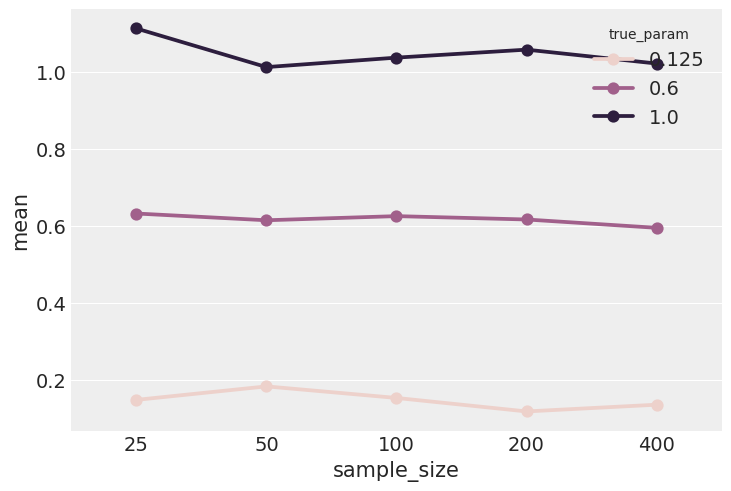

In [11]:
fig, ax = plt.subplots()

sns.pointplot(data=summaries, x="sample_size", y="mean", hue="true_param", ax=ax)

# Estudo de simulação bayesiano

```python
positive_continuous = [
    'Exponential',
    'Gamma',
    'HalfCauchy',
    'HalfFlat',
    'HalfNormal',
    'HalfStudentT',
    'InverseGamma',
    'LogNormal',
    'LogNormal',
    'PolyaGamma',
    'Rice',
    'Wald',
    'Weibull',
]
```

## Estudo das divergências

```python
np.random.seed(RANDOM_SEED)

sample = a(beta=BETAS[1]).rvs(size=SAMPLE_SIZES[0])

with pm.Model() as basic_model:
    beta = pm.Gamma("beta", alpha=1, beta=1)
    y = A("y", beta=beta, observed=sample)
```

```python
idata = {}

targets = [.80, .85, .90, .95, .99]

with basic_model:
    for target_accept in targets:
        idata[target_accept] = pm.sample(draws=5000,
                                         chains=4,
                                         tune=2000,
                                         target_accept=target_accept,
                                         return_inferencedata=True,
                                         random_seed=RNG)

pd.DataFrame({
    "step_size": [float(idata[target].sample_stats.step_size.mean()) for target in targets],
    "divergent": [float(idata[target].sample_stats.diverging.sum()) for target in targets],
    "delta_target": targets,
})
```

## Priori $\operatorname{Gama}(1, 1)$

\begin{align}
    \beta &\sim \operatorname{Gama}(1, 1) \\
    X &\sim \operatorname{A}(\beta)
\end{align}

```python
np.random.seed(RANDOM_SEED)

sample = a(beta=BETAS[0]).rvs(size=SAMPLE_SIZES[0])

with pm.Model() as basic_model:
    beta = pm.Gamma("beta", alpha=1, beta=1)
    y = A("y", beta=beta, observed=sample)
    
    
    idata = pm.sample(draws=5000,           
                      chains=4,           
                      tune=2000,           
                      target_accept=0.95,           
                      return_inferencedata=True,           
                      random_seed=RNG)
    # pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    # az.plot_ppc(idata, mean=False, observed_rug=True, num_pp_samples=100)
```

In [12]:
simulations = {}

for beta in BETAS:
    simulations[beta] = {}
    rv = a(beta=beta)
    print(f"{beta = }")
    for n in SAMPLE_SIZES:
        simulations[beta][n] = []
        print(f"\t{n = }")
        model = bayesian.make_model(
            sample = rv.rvs(size=n),
            prior=pm.Gamma,
            prior_params={"name": "beta", "alpha": 1, "beta": 1},
        )
        for i in range(REPLICATIONS):
            sample = rv.rvs(size=n)
            simulation = bayesian.simulate(
                param=beta,
                sample=sample,
                model=model,
                alpha=.05,
                sampler_params={
                    "draws": 1000,
                    "chains": 2,
                    "tune": 1000,
                    "target_accept": .99,
                    "return_inferencedata": True,
                    "random_seed": RNG,
                    "cores": 2
                }
            )
            simulations[beta][n].append(simulation)

beta = 0.125
	n = 25


Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

	n = 50


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

	n = 100


Output()

Output()

Output()

Output()

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Output()

Output()

	n = 200


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

	n = 400


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

beta = 0.6
	n = 25


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

	n = 50


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

	n = 100


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

	n = 200


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

	n = 400


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

beta = 1.0
	n = 25


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Output()

Output()

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Output()

	n = 50


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

	n = 100


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

	n = 200


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

	n = 400


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [16]:
simulations


{
    0.125: {
        25: [
            Simulation(
                sample_size=400,
                true_param=1.0,
                estimated_param=1.1199511365306067,
                ci=ConfidenceInterval(lower=1.113003727554309, upper=1.1268985455069045)
            ),
            Simulation(
                sample_size=400,
                true_param=1.0,
                estimated_param=1.1199511365306067,
                ci=ConfidenceInterval(lower=1.113003727554309, upper=1.1268985455069045)
            ),
            Simulation(
                sample_size=400,
                true_param=1.0,
                estimated_param=1.1199511365306067,
                ci=ConfidenceInterval(lower=1.113003727554309, upper=1.1268985455069045)
            ),
            Simulation(
                sample_size=400,
                true_param=1.0,
                estimated_param=1.1199511365306067,
                ci=ConfidenceInterval(lower=1.113003727554309, upper=1.1268985455069045)
     

In [13]:
summaries = pd.DataFrame([
    summarize(simulations[beta][n])
    for beta in simulations
    for n in simulations[beta]
])

In [14]:
summaries

,true_param,sample_size,mean,bias,mse,coverage_probability
0,1.0,400,1.119951,0.119951,0.014388,0.0
1,1.0,400,1.119951,0.119951,0.014388,0.0
2,1.0,400,1.119951,0.119951,0.014388,0.0
3,1.0,400,1.119951,0.119951,0.014388,0.0
4,1.0,400,1.119951,0.119951,0.014388,0.0
5,1.0,400,1.119951,0.119951,0.014388,0.0
6,1.0,400,1.119951,0.119951,0.014388,0.0
7,1.0,400,1.119951,0.119951,0.014388,0.0
8,1.0,400,1.119951,0.119951,0.014388,0.0
9,1.0,400,1.119951,0.119951,0.014388,0.0


<Axes: xlabel='sample_size', ylabel='mean'>

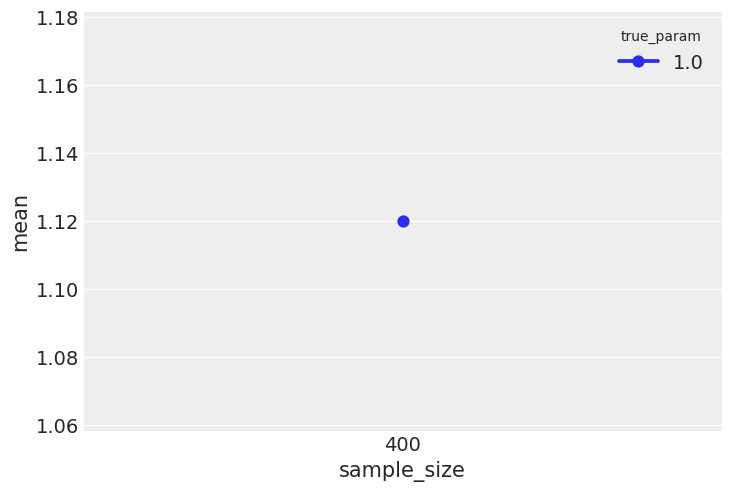

In [15]:
fig, ax = plt.subplots()

sns.pointplot(data=summaries, x="sample_size", y="mean", hue="true_param", ax=ax)

# Apêndice

In [ ]:
fig, ax = plt.subplots()

beta = 30
samples = pm.draw(A.dist(beta), 1000)
rv = a(beta=beta)

xs = np.linspace(rv.ppf(0.001), rv.ppf(0.99), num=200)
ys = rv.pdf(xs)
sns.histplot(samples, stat="density", ax=ax)
sns.lineplot(x=xs, y=ys, color="orange", ax=ax)
ax.set(xlim=(0, 50), ylim=(0,0.2))

In [ ]:
sample = a(beta=beta).rvs(100)

In [ ]:
with pm.Model() as model:
    beta = pm.Gamma("beta", 1, 1)
    y = A("y", beta=beta, observed=sample)

In [ ]:
with model:
    idata = pm.sample(draws=1000, chains=4, return_inferencedata=True)

In [ ]:
az.plot_trace(idata)

In [ ]:
az.plot_posterior(idata)

In [ ]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

In [ ]:
ax = az.plot_ppc(idata, mean=False, observed_rug=True, num_pp_samples=100)
ax.set_xlim(0, 100)